In [1]:
import os
import sys
sys.path.append('/usr/src/code/src')
os.chdir('/usr/src/code/')

import torch

from src.models.UNet import UNet, UNet2DWrapper, UNet_res, UNet_Tranformer
from src.utils.other_utils import *
from src.pdlmc.constraints import classifier_constraint, brightness_constraint, center_constraint
from src.utils.samplers import *
from src.utils.trainers import *
from src.utils.schedulers import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
timesteps = 250
sigma = 25.0
eps = 1e-3

model = UNet_Tranformer(partial(marginal_prob_std, sigma=sigma, device=device))
model.load_state_dict(torch.load("unet_transformer.pth"))
model = model.to(device)
classifier = torch.load("mnist_classifier.pkl", weights_only=False)

# Classifier

	 Sampling images: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


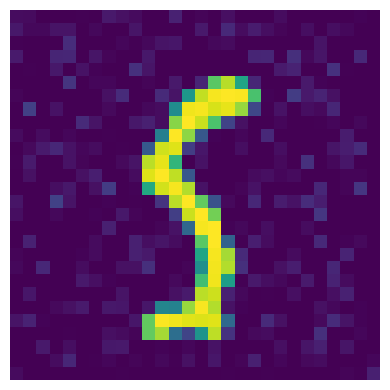

In [13]:
timesteps = 400
eps = 1e-3

vesde_sampler = VESDESampler(device=device, img_ch=IMG_CH, img_size=IMG_SIZE)
sample_timesteps = torch.linspace(eps, 1.0, timesteps, device=device)
img = sample_images(
    model=model,
    sampler=vesde_sampler,
    timesteps=sample_timesteps,
    device=device,
    sample_size=1,
    plot=True,
    save=False,
)

In [ ]:
gfuncs = [
    partial(classifier_constraint, classifier=classifier, target_class=9, epsilon=0.01)
]

lmc_steps: int = 1
update_steps: int = 3
step_size: float = 2
step_size_lambda: float = 0.2
timesteps = 400

pdlmc_sampler = PDLMCVESampler(
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

sample_timesteps = torch.linspace(eps, 1.0, timesteps, device=device)
img = sample_images(
    model=model,
    sampler= pdlmc_sampler,
    timesteps=sample_timesteps,
    device=device,
    sample_size=1,
    plot=True,
    save=False,
    update_steps = update_steps,
)

	 Sampling images:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Generate 100 images
timesteps = 400
eps = 1e-3

vesde_sampler = VESDESampler(device=device, img_ch=IMG_CH, img_size=IMG_SIZE)
sample_timesteps = torch.linspace(eps, 1.0, timesteps, device=device)

imgs_vesde = sample_images(
    model=model,
    sampler=vesde_sampler,
    timesteps=sample_timesteps,
    device=device,
    sample_size=100,
    plot=False,
    save=False,
)

print(f"Generated {len(imgs_vesde)} images using VESDESampler.")
calculate_class_proportions(imgs_vesde, classifier, n_classes=N_CLASSES, device=device)


	 Sampling images:   1%|          | 1/100 [00:01<02:25,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
gfuncs = [
    partial(classifier_constraint, classifier=classifier, target_class=9, epsilon=0.01)
]
lmc_steps: int = 1
step_size: float = 2
step_size_lambda: float = 0.75
timesteps = 500
sample_timesteps = torch.linspace(eps, 1.0, timesteps, device=device)

pdlmc_sampler = PDLMCVESampler(
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

imgs_pdlmc = img = sample_images(
    model=model,
    sampler=pdlmc_sampler,
    timesteps=sample_timesteps,
    device=device,
    sample_size=100,
    plot=False,
    save=False,
)
print(f"\nGenerated {len(imgs_pdlmc)} images using PDLMCSampler.")
calculate_class_proportions(imgs_pdlmc, classifier, n_classes=N_CLASSES, device=device)

	 Sampling images: 100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


Generated 100 images using PDLMCSampler.
0: 0.32  1: 0.00  2: 0.00  3: 0.00  4: 0.00  5: 0.00  6: 0.00  7: 0.00  8: 0.00  9: 0.68  

# Brightness

	 Sampling images: 100%|██████████| 1/1 [00:14<00:00, 14.24s/it]


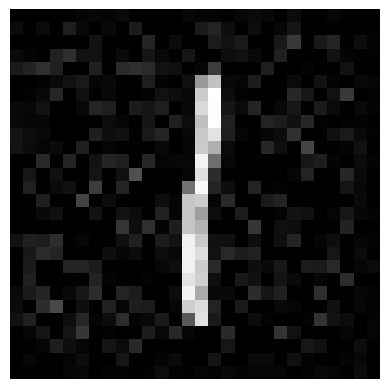

<Figure size 400x400 with 0 Axes>


Generated 1 images using PDLMCSampler.


0.05441856384277344

In [8]:
gfuncs = [
    partial(brightness_constraint, target=0.1, tol=0.005)
]

lmc_steps: int = 1
update_steps: int = 10
step_size: float = 0.1
step_size_lambda: float = 0.01
timesteps = 500

sample_timesteps = torch.linspace(eps, 1.0, timesteps, device=device)

pdlmc_sampler = PDLMCVESampler(
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

imgs_pdlmc = img = sample_images(
    model=model,
    sampler=pdlmc_sampler,
    timesteps=sample_timesteps,
    device=device,
    sample_size=1,
    plot=True,
    save=False,
    update_steps=update_steps
)

print(f"\nGenerated {len(imgs_pdlmc)} images using PDLMCSampler.")
calculate_mean_brightness(imgs_pdlmc)

# Centering

	 Sampling images: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


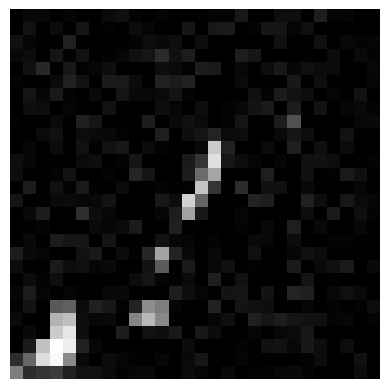

<Figure size 400x400 with 0 Axes>


Generated 1 images using PDLMCSampler.


In [ ]:
gfuncs = [
    partial(center_constraint, center=(6, 20))
]

lmc_steps: int = 1
update_steps: int = 10
step_size: float = 0.1
step_size_lambda: float = 0.01
timesteps = 500

sample_timesteps = torch.linspace(eps, 1.0, timesteps, device=device)

pdlmc_sampler = PDLMCVESampler(
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

imgs_pdlmc = img = sample_images(
    model=model,
    sampler=pdlmc_sampler,
    timesteps=sample_timesteps,
    device=device,
    sample_size=1,
    plot=True,
    save=False,
    update_steps=update_steps
)

print(f"\nGenerated {len(imgs_pdlmc)} images using PDLMCSampler.")